# Analysis of Lamb's-Ear Tracks

## Importing Dependencies and Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import cv2
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import scipy.signal as scipysignal
import matplotlib
import scipy.stats as stats
import warnings; warnings.simplefilter('ignore')
import math
min_frames = 120
ppmm = 1080/385
fps =60

## Import Data

In [2]:
bee_path = pd.DataFrame()
frameN = []
file_name = [1,2,3,4]
num_bees = 0
for fn in file_name:
    if ((fn==3)):
        bee_file = np.arange(1,32,1)
    elif (fn==2):
        bee_file = np.arange(1,32,1)
    elif (fn==1):
        bee_file = np.arange(1,36,1)
    elif (fn==4):
        bee_file = np.arange(1,27,1)
    
    for f in bee_file:
        bee_path1 = pd.read_csv('LambsEar_tracks/LEV_%d'%(fn)+'_'+str(f)+'.csv')
        if (len(bee_path1.x0)>=min_frames):
            frameN = np.append(frameN,len(bee_path1)) 
            bee_path1 = bee_path1.rename(columns={'Unnamed: 0': 'beeN_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'nframe': 'nframe_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'x0': 'x0_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'y0': 'y0_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'area': 'area_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'x': 'x_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'y': 'y_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'occlusion': 'occlusion_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'sx': 'sx_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'sy': 'sy_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'method': 'method_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'px': 'px_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'py': 'py_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'x0i': 'x0i_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'y0i': 'y0i_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'sx11': 'sx11_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'sy11': 'sy11_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'speed': 'speed_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'speeds': 'speeds_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'angle': 'angle_%d'%(fn)+str(f)})
            bee_path1 = bee_path1.rename(columns={'delta_area': 'delta_area_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'mse_area': 'mse_area_%d'%(fn)+str('%02d' %f)})
            bee_path1 = bee_path1.rename(columns={'state': 'state_%d'%(fn)+str('%02d' %f)})
            
            num_bees+=1

            bee_path = pd.concat([bee_path, bee_path1], axis=1)

bee_path.head()    

,beeN_102,nframe_102,x0_102,y0_102,area_102,x_102,y_102,occlusion_102,sx_102,sy_102,...,x0i_426,y0i_426,sx11_426,sy11_426,speed_426,speeds_426,angle_426,delta_area_426,mse_area_426,state_426
0,0.0,168.0,269.5,393.5,NaN,269.5,393.5,0.0,269.500000,393.500000,...,1431.5,849.0,1431.500000,849.000000,NaN,NaN,NaN,NaN,NaN,Int_detection
1,1.0,169.0,268.0,393.5,NaN,268.0,393.5,0.0,268.750000,393.500000,...,1431.5,849.5,1431.500000,849.250000,0.5,0.250000,NaN,NaN,NaN,0
2,2.0,170.0,269.5,393.5,NaN,269.5,393.5,0.0,269.000000,393.500000,...,1432.5,849.5,1431.833333,849.333333,1.0,0.343592,-75.963757,NaN,NaN,0
3,3.0,171.0,254.5,365.5,91.0,254.5,365.5,0.0,264.000000,384.166667,...,NaN,NaN,1432.000000,849.375000,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,172.0,270.5,393.0,NaN,270.5,393.0,0.0,264.833333,384.000000,...,NaN,NaN,1432.100000,849.400000,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
beesnum = np.zeros(shape=(0,0))
for r in range(1000):
    if 'x0_'+str(r) in bee_path.columns:
        beesnum = np.append(beesnum,r)
beesnum = beesnum.astype(int)



In [7]:
all_bees = pd.DataFrame()
for fn in file_name:
    if ((fn==3)| (fn==2)):
        bee_file = np.arange(1,13,1)
    elif (fn==1):
        bee_file = np.arange(1,21,1)
    elif (fn==5):
        bee_file = np.arange(1,12,1)
    
    for f in bee_file:
        all_bees1 = pd.read_csv('LambsEar_tracks/LEV_%d'%(fn)+'_'+str(f)+'.csv')
        if (len(all_bees1.x0)>=min_frames):
            all_bees = all_bees.append(all_bees1, ignore_index = True)

## Plot Tracks

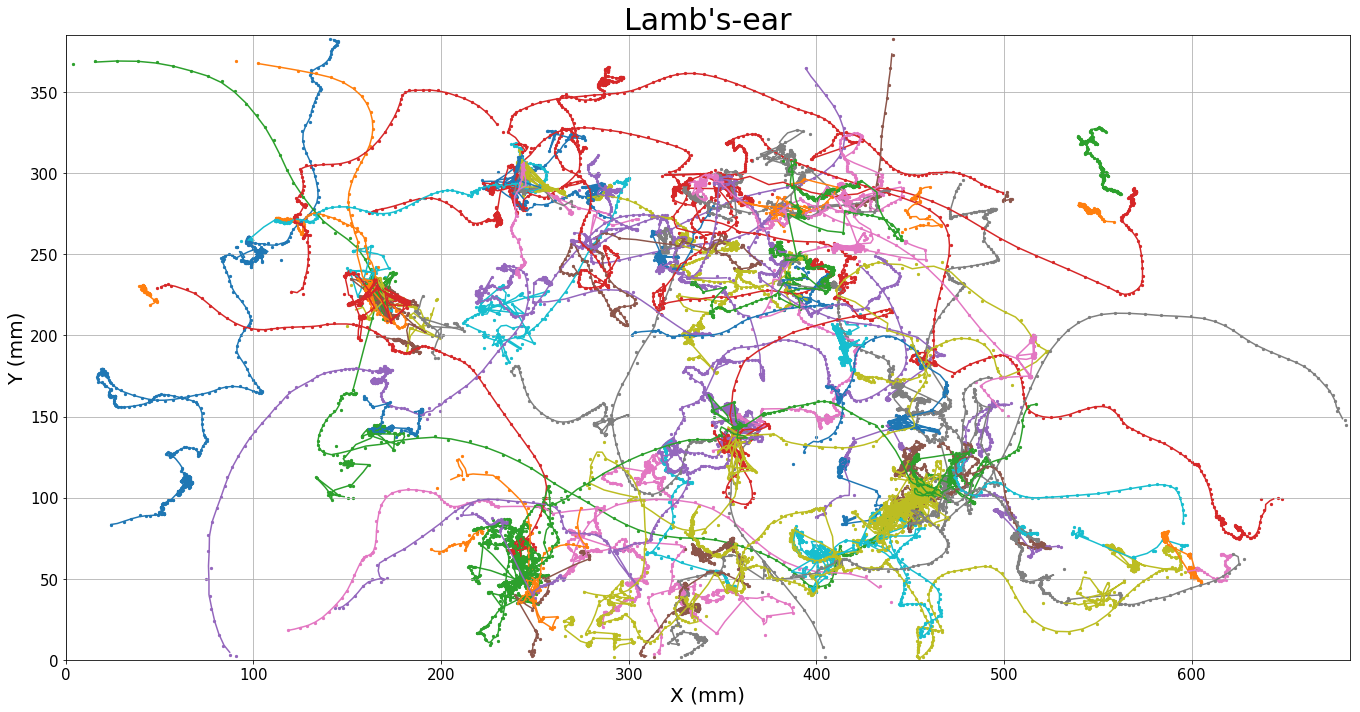

In [8]:
plt.figure(figsize=(19,10))
for bn in beesnum:
    plt.scatter((bee_path['x0_%d'%(bn)]/ppmm), ((1080-bee_path['y0_%d'%(bn)])/ppmm), label = (bn), s=5 )
    plt.plot((bee_path['sx_%d'%(bn)]/ppmm), ((1080-bee_path['sy_%d'%(bn)])/ppmm), label='_nolegend_')
    
plt.grid()
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=18, title='Track Number', title_fontsize = 15)
plt.xlim(0,1920/ppmm)
plt.ylim(0,1080/ppmm)
plt.title('Lamb\'s-ear', fontsize=30)
# plt.suptitle('(29731 Frames | 8:15 minutes)',y = -0.0001, x= 0.1)
plt.xlabel('X (mm)', fontsize=20)
plt.ylabel('Y (mm)', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.savefig('LambsEar_graphs/LambsEar_tracks.pdf', format='pdf', dpi=600)
plt.show()

## Plot Heatmap

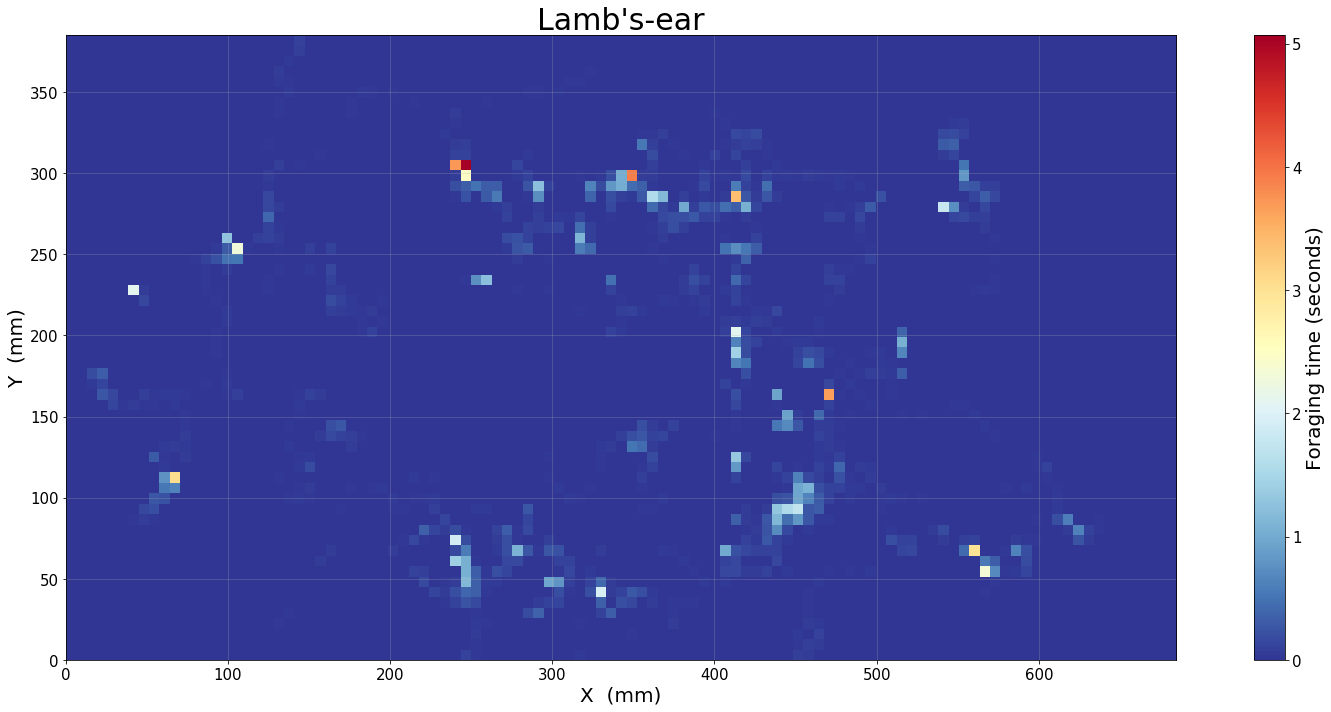

In [9]:
plt.figure(figsize=(22,10))
heatmap, xedges, yedges = np.histogram2d((all_bees['y0']/ppmm).dropna(),(all_bees['x0']/ppmm).dropna(), bins=(60,107), range = [[0, 1080/ppmm], [0, 1920/ppmm]])
extent = [yedges[0], yedges[-1],xedges[0], xedges[-1]]

plt.grid(alpha =0.3)
plt.xlim(0,1920/ppmm)
plt.ylim(0,1080/ppmm)
plt.title('Lamb\'s-ear', fontsize=30)
# plt.suptitle('(29731 Frames | 8:15 minutes)',y = -0.0001, x= 0.1)
plt.xlabel('X  (mm)', fontsize=20)
plt.ylabel('Y  (mm)', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.imshow(heatmap/fps, interpolation='nearest',extent=extent,cmap='RdYlBu_r')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=15)
cb.set_label(label = 'Foraging time (seconds)', fontsize=20)
plt.tight_layout()

plt.savefig('LambsEar_graphs/LambsEar_heatmap.pdf', format='pdf', dpi=600)

plt.show()

## Plot Distribution of Speed

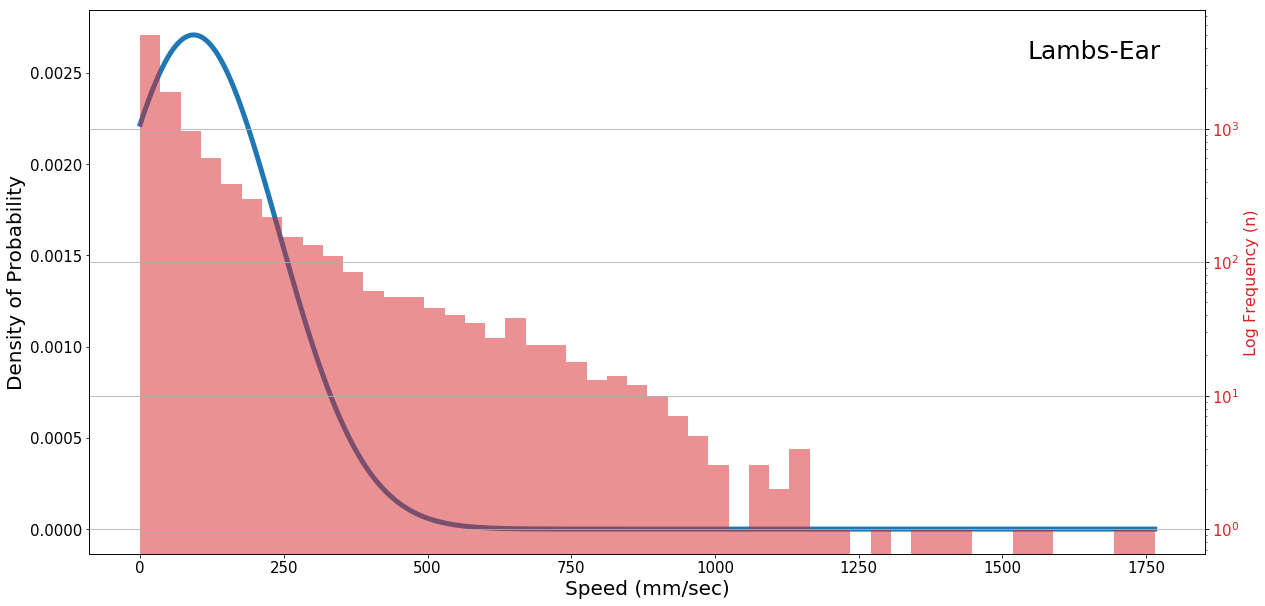

In [10]:
fig = plt.figure(figsize=(20,10))
speed = ((fps*all_bees['speed'])/ppmm).dropna()
speed_pdf = stats.norm.pdf(sorted(speed), np.mean(speed), np.std(speed))
plt.plot(sorted(speed),speed_pdf, linewidth =5)
plt.xlabel('Speed (mm/sec)', fontsize=20)
plt.ylabel('Density of Probability', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Lambs-Ear', fontsize=25, x=0.9,y=0.9)

ax2 = plt.twinx()
color = 'tab:red'
ax2.set_ylabel('Log Frequency (n)', color=color,fontsize=16)  # we already handled the x-label with ax1
ax2.hist(speed, log=True, stacked = False, histtype='bar', normed = False , bins=50, color = color, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color,labelsize=15)

plt.grid()
plt.savefig('LambsEar_graphs/LambsEar_heatmap.pdf', format='pdf', dpi=150)

plt.show()

## Plot Distribution of Turn-angle

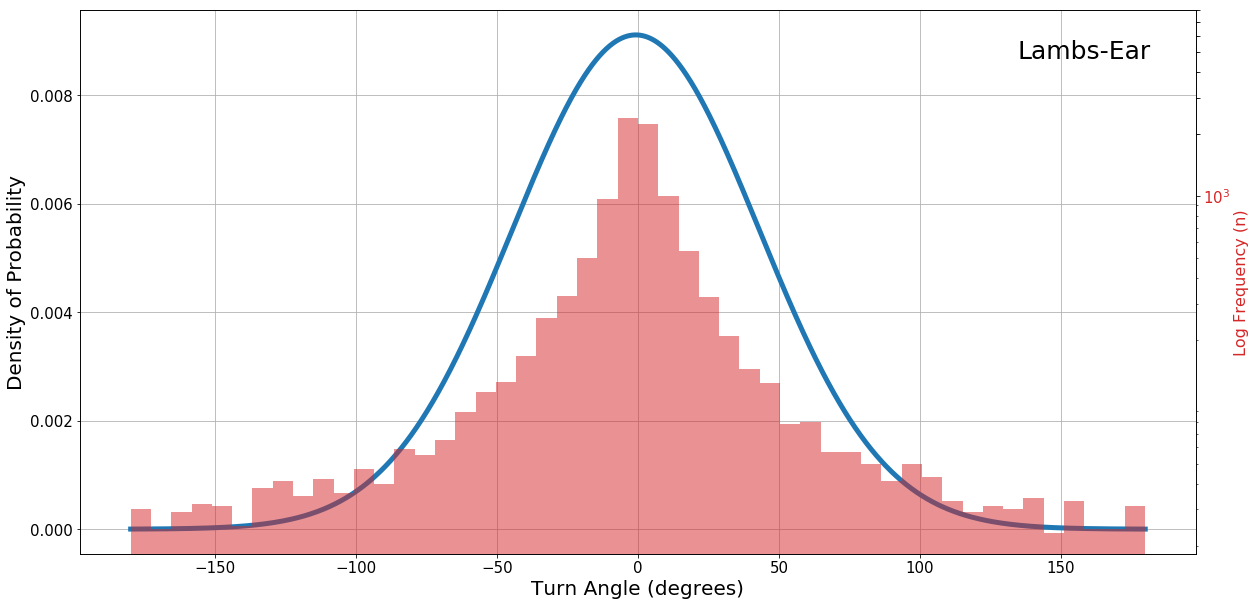

In [11]:
fig = plt.figure(figsize=(20,10))

angle = all_bees['angle'].dropna()
angle_pdf = stats.norm.pdf(sorted(angle), np.mean(angle), np.std(angle))
plt.plot(sorted(angle),angle_pdf, linewidth =5)
plt.xlabel('Turn Angle (degrees)', fontsize=20)
plt.ylabel('Density of Probability', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.title('Lambs-Ear', fontsize=25, x=0.9,y=0.9)

ax2 = plt.twinx()
color = 'tab:red'
ax2.set_ylabel('Log Frequency (n)', color=color,fontsize=16 )  # we already handled the x-label with ax1
ax2.hist(angle, log=True, stacked = False, histtype='bar', normed = False , bins=50, color = color, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color,labelsize=15)
ax2.set_yticks([1000,2000,3000,4000,5000,6000,7000,8000])
plt.savefig('LambsEar_graphs/LambsEar_turnangle.pdf', format='pdf', dpi=150)


plt.show()

## Plot Honeybee Position

In [12]:
bee_details =  pd.DataFrame(columns=['bee_num' , 'nframes', 'recorded', 'under_carpet', 'BS', 'DL','speed_mean', 'speed_max','distance'])
for bn in beesnum:
    nframes = bee_path['nframe_'+str(bn)].count()
    recorded = bee_path['x0_'+str(bn)].count()
    BS = bee_path['area_'+str(bn)].count()
    speed_mean =bee_path['speed_'+str(bn)].mean()
    speed_max =bee_path['speed_'+str(bn)].max() 
    distance =bee_path['speed_'+str(bn)].sum() 
    under_carpet = bee_path['nframe_'+str(bn)][bee_path['state_'+str(bn)] == '1'].count()
    DL = recorded - BS
    bn = str(bn)
    
    newdata = [bn, nframes, recorded, under_carpet, BS, DL, speed_mean, speed_max, distance]
    bee_details.loc[len(bee_details)] = newdata

bee_details
mean_time = bee_details.nframes.mean()/fps


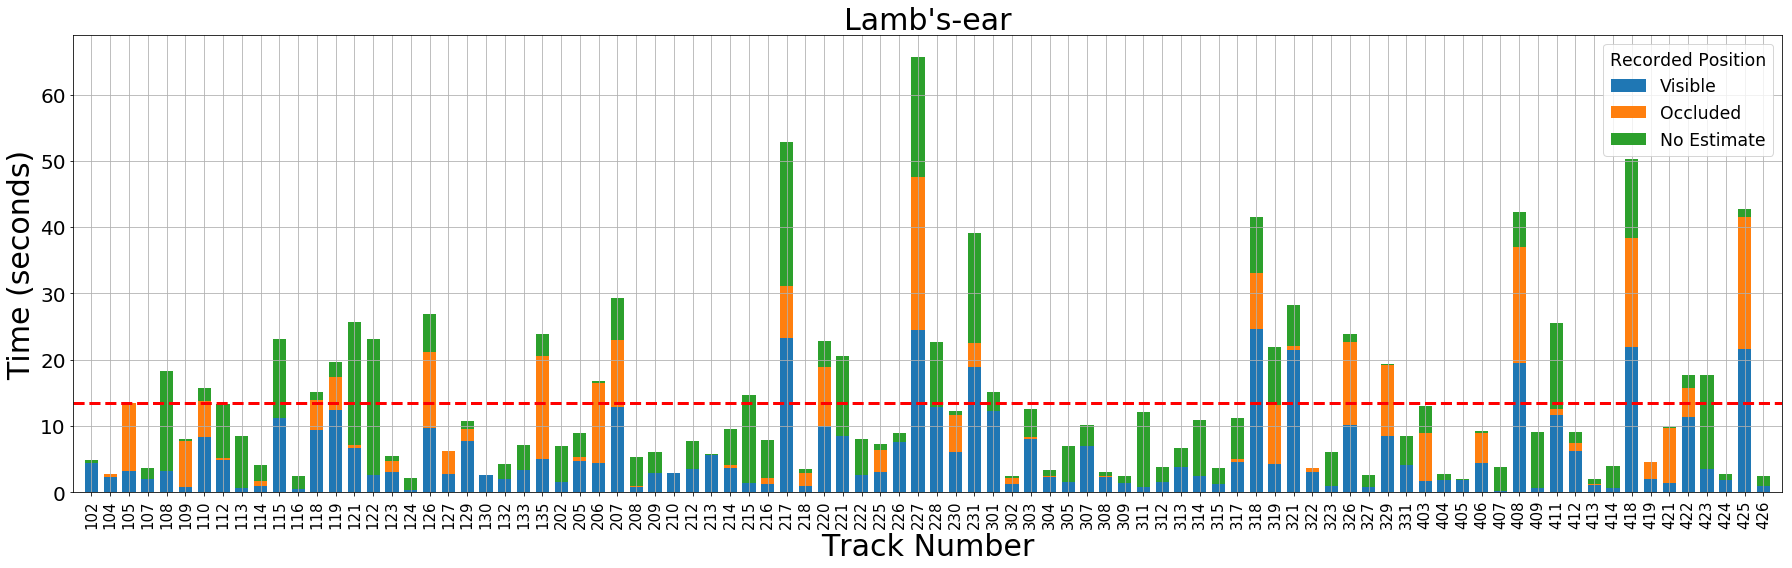

In [13]:
plt.figure(figsize=(25,8))
p1 = plt.bar(bee_details.bee_num, bee_details.recorded/60, width = 0.7, align='center')
p2 = plt.bar(bee_details.bee_num, bee_details.under_carpet/60, width = 0.7, align='center', bottom = (bee_details.recorded/60))
p3 = plt.bar(bee_details.bee_num, (bee_details.nframes-bee_details.recorded-bee_details.under_carpet)/60, width = 0.7, align='center', bottom = (bee_details.recorded+bee_details.under_carpet)/60)
plt.legend((p1[0], p2[0],p3[0]), ('Visible', 'Occluded','No Estimate'),title = 'Recorded Position', title_fontsize= 'xx-large' , fontsize = 'xx-large' )
plt.grid()
plt.xlim(-1,90)
# plt.ylim(0,1080/ppmm)
plt.title('Lamb\'s-ear', fontsize=30)
plt.xlabel('Track Number', fontsize=30)
plt.ylabel('Time (seconds)', fontsize=30)
plt.xticks(rotation='vertical', fontsize = 15)
plt.yticks(np.arange(0,110,10), fontsize = 20)

ax2 = plt.gca()
color = 'tab:red'
ax2.plot([-1,90],[mean_time,mean_time], color = 'r', linewidth = 3, linestyle = '--')


plt.tight_layout()
plt.savefig('LambsEar_graphs/LambsEar_beeposition.pdf', format='pdf', dpi=600)
plt.show()

## Plot Detection Stats and Honeybee Position

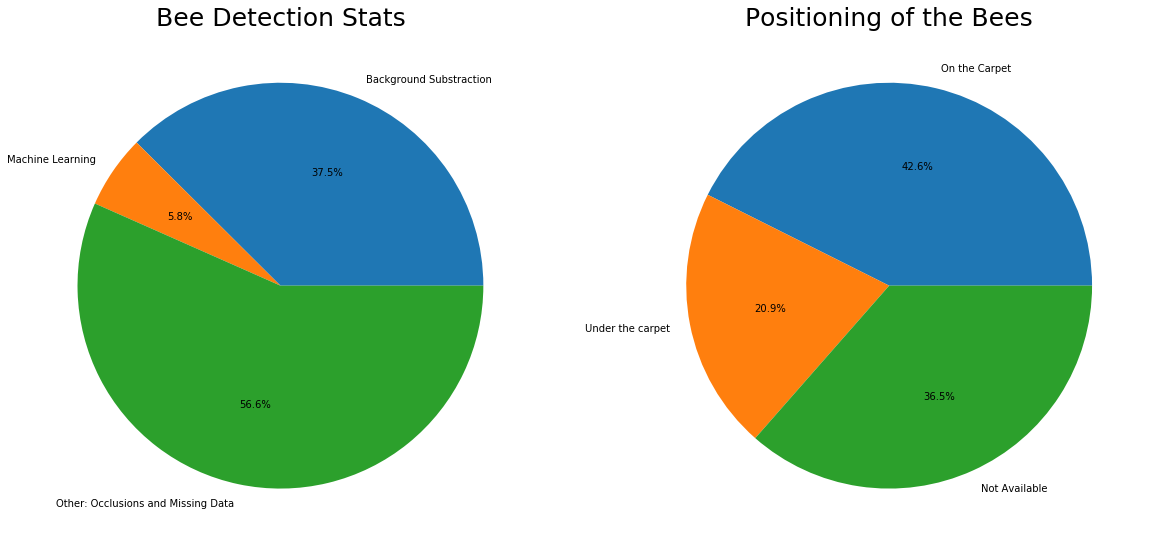

In [14]:
fig = plt.figure(figsize=(20,10))
BS_recorded = all_bees.area.count()
ML_recorded = all_bees.x0.count() - all_bees.area.count()
Not_recorded = all_bees.x0.last_valid_index() - all_bees.x0.count()
state_0 = all_bees.state[all_bees.state == '0'].count()
state_1 = all_bees.state[all_bees.state == '1'].count()
state_2 = all_bees.x0.last_valid_index() - (state_0+state_1)
    #Alg1
plt.subplot(121)
labels = 'Background Substraction', 'Machine Learning', 'Other: Occlusions and Missing Data'
sizes = [BS_recorded, ML_recorded, Not_recorded]
plt.title('Bee Detection Stats', fontsize=25)
plt.pie(sizes, labels=labels,  autopct='%1.1f%%')

plt.subplot(122)
labels1 = 'On the Carpet', 'Under the carpet', 'Not Available'
sizes1 = [state_0, state_1, state_2]
plt.title('Positioning of the Bees', fontsize=25)
plt.pie(sizes1, labels=labels1,  autopct='%1.1f%%')
plt.savefig('LambsEar_graphs/LambsEar_stats.pdf', format='pdf', dpi=600)

plt.show()